
# Export TensorBoard Histograms (grads/* and weights/*) to Images

This notebook reads a TensorBoard **event file or log directory**, lists your histogram tags (e.g. `grads/*`, `weights/*`), and exports:
- **Distributions-over-time** plots (percentile bands over steps), and
- *(optional)* **per-step histogram** plots

It works with logs generated via PyTorch's `SummaryWriter` or TensorFlow, including code like:

```python
writer.add_histogram(f"weights/{name}", param.data, step)
writer.add_histogram(f"grads/{name}",   param.grad, step)
```

> **Tip:** If you logged very large runs, change `SIZE_GUIDANCE` below to limit how much is loaded.


In [1]:

from pathlib import Path

# === Configuration ===
# Point this to your runs/ directory OR directly to a single event* file
LOGDIR = "/workspaces/msc-thesis-recurrent-health-modeling/_runs/attention_pooling_query_curr_20251020_180454/events.out.tfevents.1760983508.6ede11525d93.72728.0"

# Where to save exported images/CSVs
OUT_DIR = "./tb_hist_exports"

# Prefix filters; leave as-is to target your code's tags
TAG_PREFIXES = ["grads/", "weights/"]

# Also dump one histogram image per step?
EXPORT_PER_STEP = False

# Export summary percentiles to CSV for each tag?
EXPORT_CSV = True

# Load limits; 0 means "no limit" (load all). You may tune for speed/memory.
SIZE_GUIDANCE = {
    'scalars':    0,
    'histograms': 0,
    'images':     0,
    'audio':      0,
}
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

print("Config OK. Edit LOGDIR to your path before running the next cells.")


Config OK. Edit LOGDIR to your path before running the next cells.


In [103]:
import os, math, csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_event_accumulator(logdir_or_event, size_guidance):
    ea = EventAccumulator(logdir_or_event, size_guidance=size_guidance)
    ea.Reload()
    return ea

def list_histogram_tags(ea, prefixes=None):
    tags = ea.Tags().get('histograms', []) or []
    if prefixes:
        tags = [t for t in tags if any(t.startswith(p) for p in prefixes)]
    return sorted(tags)

def load_hist_series(ea, tag):
    """Return list of (step, edges[np.ndarray], counts[np.ndarray]) for a histogram tag."""
    series = []
    for ev in ea.Histograms(tag):
        h = ev.histogram_value
        edges = np.array([h.min] + list(h.bucket_limit), dtype=float)
        counts = np.array(h.bucket, dtype=float)
        series.append((ev.step, edges, counts))
    return series

def _percentiles_from_hist(edges, counts, percentiles):
    # Approximate percentiles using bucket midpoints weighted by counts.
    mids = (edges[:-1] + edges[1:]) / 2.0
    total = counts.sum()
    if total <= 0:
        return [np.nan for _ in percentiles]
    # Weighted CDF over buckets
    cdf = np.cumsum(counts) / total
    vals = []
    for p in percentiles:
        q = p / 100.0
        idx = np.searchsorted(cdf, q)
        idx = np.clip(idx, 0, len(mids)-1)
        vals.append(mids[idx])
    return vals

def compute_time_summary(series, percentiles=(10,25,50,75,90)):
    steps = []
    perc = {p: [] for p in percentiles}
    minv, maxv = [], []
    for step, edges, counts in series:
        steps.append(step)
        for p, v in zip(percentiles, _percentiles_from_hist(edges, counts, percentiles)):
            perc[p].append(v)
        minv.append(edges[0]); maxv.append(edges[-1])
    return steps, perc, minv, maxv



In [109]:
import seaborn as sns

def rebin_histogram_logscale(edges, counts, nbins_per_decade=10,
                             vmin_exp=-8, vmax_exp=-1,
                             symmetric=True, density=False):
    """
    Rebin TensorBoard histogram (edges, counts) into logarithmic bins.

    Parameters
    ----------
    nbins_per_decade : int
        How many bins per factor of 10 (e.g. 10 -> bins for 1e-8, 2e-8, … 1e-7).
    vmin_exp, vmax_exp : float
        10**vmin_exp to 10**vmax_exp defines the abs(value) range.
    symmetric : bool
        If True, mirror bins to negative side.
    density : bool
        Normalize to probability density.
    """
    # Build log-spaced positive edges
    pos_edges = np.logspace(vmin_exp, vmax_exp,
                            int((vmax_exp - vmin_exp) * nbins_per_decade) + 1)
    if symmetric:
        new_edges = np.concatenate((-pos_edges[::-1], pos_edges))
    else:
        new_edges = pos_edges

    # Rebin via overlap, like before
    new_counts = np.zeros(len(new_edges) - 1, dtype=float)
    old_left, old_right = edges[:-1], edges[1:]
    old_width = np.maximum(old_right - old_left, 1e-20)
    for l, r, c, w in zip(old_left, old_right, counts, old_width):
        if c == 0:
            continue
        i_start = np.searchsorted(new_edges, l, side="right") - 1
        i_end = np.searchsorted(new_edges, r, side="left")
        i_start = np.clip(i_start, 0, len(new_counts)-1)
        i_end = np.clip(i_end, 0, len(new_counts))
        for i in range(i_start, i_end):
            a, b = new_edges[i], new_edges[i+1]
            overlap = max(0.0, min(r, b) - max(l, a))
            if overlap > 0:
                new_counts[i] += c * (overlap / w)

    if density:
        area = (new_counts * (new_edges[1] - new_edges[0])).sum()
        if area > 0:
            new_counts /= area

    return new_edges, new_counts

def plot_histogram_logscale(
    tag,
    step,
    edges,
    counts,
    nbins_per_decade=10,
    vmin_exp=-8,
    vmax_exp=-1,
    yscale="log",
    smooth_window=0,
    out_png=None,
    figsize=(9, 3),
    dpi=100
):
    """
    Pretty log-binned histogram plot using seaborn styling.

    - Uses log-spaced bins symmetric around zero.
    - Optional moving-average smoothing.
    - Seaborn aesthetic (grid, palette, clean font).
    """

    # --- Rebin (reuse earlier rebin_histogram_logscale function) ---
    new_edges, new_counts = rebin_histogram_logscale(
        edges,
        counts,
        nbins_per_decade=nbins_per_decade,
        vmin_exp=vmin_exp,
        vmax_exp=vmax_exp,
        symmetric=True,
    )

    # Optional smoothing (moving average)
    if smooth_window and smooth_window > 2:
        kernel = np.ones(smooth_window) / smooth_window
        pad = smooth_window // 2
        padded = np.pad(new_counts, (pad, pad), mode="edge")
        new_counts = np.convolve(padded, kernel, mode="valid")

    centers = 0.5 * (new_edges[:-1] + new_edges[1:])
    widths = new_edges[1:] - new_edges[:-1]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.bar(
        centers,
        new_counts,
        width=widths,
        align="center",
        edgecolor="white",
        linewidth=0.5,
    )

    # Symmetric log x-scale for ± values
    ax.set_xscale("symlog", linthresh=10 ** (vmin_exp))
    ax.set_yscale(yscale)

    ax.set_xlabel("Gradient value", labelpad=8)
    ax.set_ylabel("Count", labelpad=8)
    ax.set_title(f"{tag} — step {step}", pad=10, fontsize=14)

    # Fancy tweaks
    sns.despine(ax=ax, trim=True)
    ax.grid(True, which="major", linestyle="--", alpha=0.4)
    ax.grid(False, which="minor")  # keep it clean

    # Adjust layout
    plt.tight_layout()

    # Save or show
    if out_png:
        plt.savefig(out_png, bbox_inches="tight")
    
    plt.close(fig)

    return fig

def plot_time_distributions(tag, steps, perc_dict, figsize=(9,4), dpi=100, out_png=None):
    """Minimal seaborn version — simple lines for each percentile."""
    xs = np.array(steps)
    order = np.argsort(xs)
    xs = xs[order]

    plt.figure(figsize=figsize, dpi=dpi)
    for p, ys in sorted(perc_dict.items()):
        ys = np.array(ys)[order]
        plt.plot(xs, ys, label=f"p{p}")

    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.title(f"{tag} — distribution over time")
    plt.legend()
    fig = plt.gcf()
    if out_png: plt.savefig(out_png)
    plt.close()
    return fig


In [44]:
ea = load_event_accumulator(LOGDIR, SIZE_GUIDANCE)
all_hist_tags = list_histogram_tags(ea, TAG_PREFIXES)
print(f"Found {len(all_hist_tags)} histogram tags matching {TAG_PREFIXES}:")
for t in all_hist_tags[:50]:
    print("  ", t)
if len(all_hist_tags) > 50:
    print("  ... (truncated)")


Found 16 histogram tags matching ['grads/', 'weights/']:
   grads/attn_bias
   grads/classifier_head.fc1.bias
   grads/classifier_head.fc1.weight
   grads/classifier_head.fc2.bias
   grads/classifier_head.fc2.weight
   grads/key_proj.weight
   grads/query_proj.weight
   grads/val_proj.weight
   weights/attn_bias
   weights/classifier_head.fc1.bias
   weights/classifier_head.fc1.weight
   weights/classifier_head.fc2.bias
   weights/classifier_head.fc2.weight
   weights/key_proj.weight
   weights/query_proj.weight
   weights/val_proj.weight


In [45]:
# You can override SELECTED_TAGS with a subset, e.g.:
# SELECTED_TAGS = [t for t in all_hist_tags if t.startswith('grads/encoder.0')]
SELECTED_TAGS = all_hist_tags
print(f"Exporting {len(SELECTED_TAGS)} tags...")


Exporting 16 tags...


In [46]:
tag = SELECTED_TAGS[2]
print(f"Processing tag: {tag}")
series = load_hist_series(ea, tag)
steps, perc_dict, minv, maxv = compute_time_summary(series)
print(f"  Steps: {len(steps)}, min val: {min(minv):.6g}, max val: {max(maxv):.6g}")

Processing tag: grads/classifier_head.fc1.weight
  Steps: 11, min val: -0.0628232, max val: 0.0525661


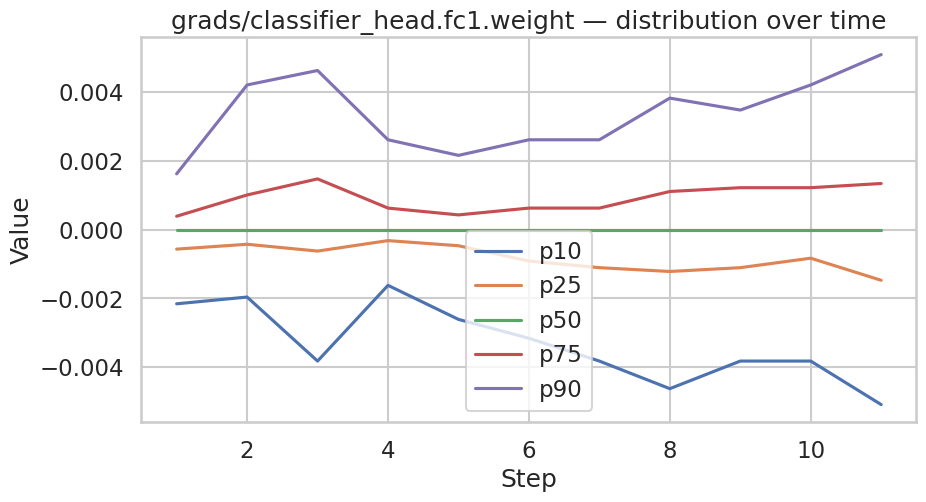

In [ ]:
plot_time_distributions(
    tag,
    steps,
    perc_dict,
    out_png=None,
    figsize=(10,5),
    
)

In [87]:
step_idx = 1
counts = series[step_idx][2]
edges = series[step_idx][1]
step = series[step_idx][0]

fig = plot_histogram_logscale(
    tag, step, edges, counts,
    nbins_per_decade=1,
    vmin_exp=-6, vmax_exp=1,
    yscale='linear',
    out_png=None,
)

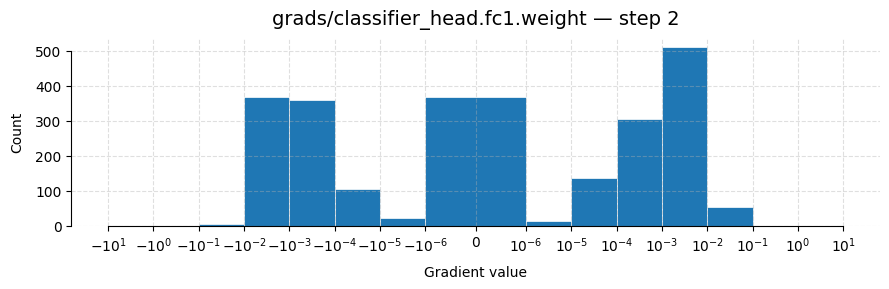

In [88]:
fig

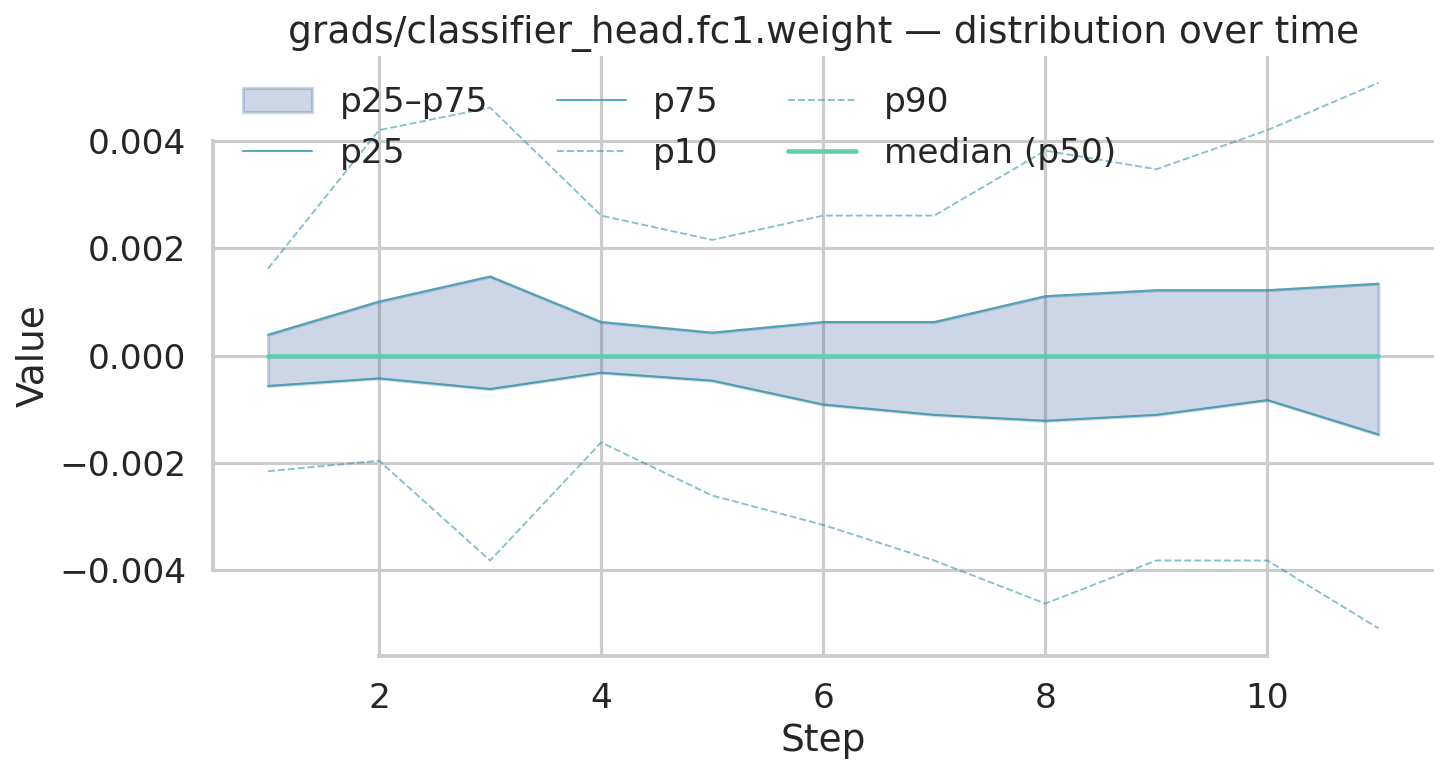

In [97]:
plot_time_distributions_sns(
    tag,
    steps,
    perc_dict,
)